In [1]:
import gym
from matplotlib import pyplot as plt

In [2]:
import numpy as np

In [3]:
from gym import envs

In [4]:
import gym_boxworld

In [5]:
env_name = 'BoxRandWorld'
env_id = env_name + 'NoFrameskip-v4'
env = gym.make(env_id, level='easy')

In [6]:
obs = env.reset()

In [7]:
color_names = {'M': 'Magenta',
          'Y': 'Yellow',
          'C': 'Cyan',
          'W': 'White',
          'G': 'Green',
          'R': 'Red',
          'S': 'Salmon',
          'P': 'Purple',
          'B': 'Black',
          'DG': 'Dark Grey',
          'GR': 'Grey'
         }

In [8]:
path = [('M',), 
        ('M', 'Y'), 
        ('Y', 'G'),
        ('G', 'R'),
        ('R', 'W')]

In [9]:
colors = {'M': (255., 0., 255.),
          'Y': (255., 255., 0.),
          'C': (0., 255., 255.,),
          'W': (255., 255., 255.),
          'G': (0., 255., 0.),
          'R': (255., 0., 0.),
          'S': (255. , 127.5, 127.5),
          'P': (127.5,   0. , 255.),
          'B': (0., 0., 0.),
          'DG': (105., 105., 105.),
          'GR': (169., 169., 169.),
         }

rgb_to_color = {v: k for k, v in colors.items()}

In [10]:
for y in range(len(obs)):
    for x in range(len(obs[y])):
        assert tuple(obs[x, y]) in colors.values(), f'not there {obs[x, y]}'

In [11]:
def to_color_obs(obs):
    return np.array([[rgb_to_color[tuple(obs[y, x])] for x in range(len(obs[y]))] for y in range(len(obs))])

In [12]:
color_obs = to_color_obs(obs)

In [13]:
for c in colors.values(): assert c in obs

In [14]:
def get_domino_position(obs, p):
    for y in range(len(obs)):
        for x in range(len(obs)):
            if domino_matches(p, obs, y, x):
                return y, x
    return None

In [15]:
def domino_matches(p, obs, y, x):
    # matches at the last pixel of p, since that's where the key we want to pick up is.
    try:
        return (obs[y, x-len(p)] in ['B', 'GR', 'DG']
                and obs[y, x+1] in ['B', 'GR', 'DG']
                and np.array_equal(obs[y, x-len(p)+1:x+1], list(p[::-1])))
    except IndexError:
        return False

In [16]:
[get_domino_position(color_obs, p) for p in path]

[(7, 6), (9, 8), (1, 7), (7, 11), (5, 6)]

In [17]:
path

[('M',), ('M', 'Y'), ('Y', 'G'), ('G', 'R'), ('R', 'W')]

In [18]:
def shortest_path(color_obs, goal):
    # goal is coordinates
    # start is assumed to be where grey dot is
    start = tuple(np.argwhere(color_obs == 'DG')[0])
    assert color_obs[start] == 'DG'
    nodes, adj_matrix = make_graph(color_obs, goal)
    return dijkstra(nodes, adj_matrix, start, goal)

In [19]:
def make_graph(obs, goal):
    # nodes that can be walked through:
    # - "self" color (dark grey)
    # - background color (grey)
    # - target key color
    nodes = {(y, x) for y in range(len(obs))
                    for x in range(len(obs[y]))
                    if (obs[y, x] in ['DG', 'GR']
                        or (y, x) == goal)}
    adj_matrix = {(y, x): {n2: 1 for n2 in [(y+1, x), (y-1, x), (y, x-1), (y, x+1)]
                                 if n2 in nodes}
                  for (y, x) in nodes}
    
    return nodes, adj_matrix

In [20]:
def dijkstra(nodes, adj_matrix, start, goal):
    distances = {n: float('inf') for n in nodes}
    predecessors = {n: None for n in nodes}
    distances[start] = 0
    visited = set()
    
    def get_min_unvisited():
        unvisited_dists = [(n, d) for (n, d) in distances.items() if n not in visited]
        return min(unvisited_dists, key=lambda t: t[1])
        
    def get_path_to(node):
        path = [node]
        while path[-1] != start:
            node = predecessors[node]
            path.append(node)  
        return path[::-1]
    
    while goal not in visited:
        current, current_dist = get_min_unvisited()
        
        for neighbor, weight_from_current_to_neighbor in adj_matrix[current].items():
            neighbor_dist = distances[neighbor]
            alt_neighbor_dist = current_dist + weight_from_current_to_neighbor
            if alt_neighbor_dist < neighbor_dist:
                assert neighbor not in visited
                distances[neighbor] = alt_neighbor_dist
                predecessors[neighbor] = current
                
        visited.add(current)

    return get_path_to(goal)

In [21]:
get_domino_position(color_obs, path[0])

(7, 6)

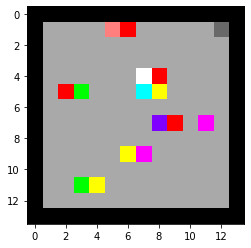

In [41]:
env.reset()
env.render()

In [44]:
obs = env.step(0)[0]
obs.shape

(14, 14, 3)

In [38]:
path[0]

('M',)

In [24]:
s = shortest_path(color_obs, get_domino_position(color_obs, path[0]))

In [25]:
s

[(8, 10), (8, 9), (8, 8), (8, 7), (7, 7), (7, 6)]

In [26]:
def moves(path):
    def tuple_diff(a, b):
        return a[0] - b[0], a[1] - b[1]
    
    diffs = [tuple_diff(a, b) for a, b in zip(path[1:], path[:-1])]
    def move(diff):
        if diff == (0, 1):
            return 3  # right
        if diff == (0, -1):
            return 2  # left
        if diff == (1, 0):
            return 1  # down  
        if diff == (-1, 0):
            return 0  # up
        raise ValueError(f'unknown diff {diff}')
    
    return [move(d) for d in diffs]

In [27]:
moves(s)

[2, 2, 2, 0, 2]

In [28]:
def exec(moves, env):
    for m in moves:
        obs, _, done, _ = env.step(m)
    return obs, done

In [29]:
exec(moves(s), env)

(array([[[255. ,   0. , 255. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ],
         [  0. ,   0. ,   0. ]],
 
        [[  0. ,   0. ,   0. ],
         [169. , 169. , 169. ],
         [169. , 169. , 169. ],
         [169. , 169. , 169. ],
         [169. , 169. , 169. ],
         [169. , 169. , 169. ],
         [  0. , 255. ,   0. ],
         [255. , 255. ,   0. ],
         [169. , 169. , 169. ],
         [169. , 169. , 169. ],
         [169. , 169. , 169. ],
         [169. , 169. , 169. ],
         [169. , 169. , 169. ],
         [  0. ,   0. ,   0. ]],
 
        [[  0. ,   0. ,   0. ],
         [169. , 169. , 169. ],
         [169. , 169. , 169. ],
  

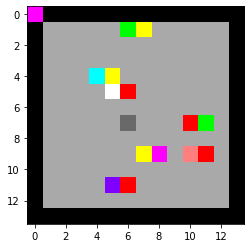

In [30]:
env.render()

In [31]:
def test_solving():
    obs = env.reset()
    color_obs = to_color_obs(obs)
    goals = [get_domino_position(color_obs, p) for p in path] 
    for goal in goals:
        color_obs = to_color_obs(obs)
        option = shortest_path(color_obs, goal)
        #env.render()
        #print(option)
        obs, done = exec(moves(option), env)
    if done:
        # print('good')
    else:
        print('not done, bad')

IndentationError: expected an indented block (3265573092.py, line 13)

In [ ]:
for i in range(100): test_solving()

good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good
good


In [ ]:
!jupyter nbconvert --to script config_template.ipynb

[NbConvertApp] WARNING | pattern 'config_template.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Exe

In [ ]:
obs

array([[[  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ]],

       [[  0. ,   0. ,   0. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [  0. ,   0. ,   0. ]],

       [[  0. ,   0. ,   0. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [255. , 127.5, 127.5],
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


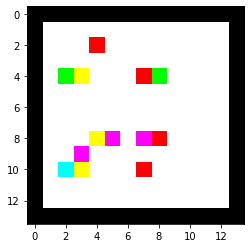

In [ ]:
plt.imshow(obs)

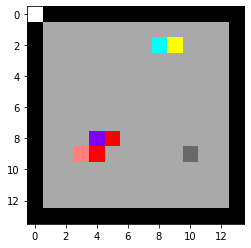

In [ ]:
env.render()

In [ ]:
obs = env.reset()

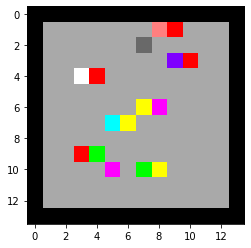

In [ ]:
env.render()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


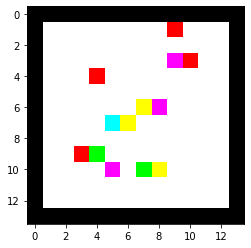

In [ ]:
plt.imshow(obs)

In [ ]:
obs.shape

(14, 14, 3)

In [ ]:
obs

array([[[  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. ]],

       [[  0. ,   0. ,   0. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [255. , 127.5, 127.5],
        [255. ,   0. ,   0. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [  0. ,   0. ,   0. ]],

       [[  0. ,   0. ,   0. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
        [169. , 169. , 169. ],
    

In [ ]:
obs2 = [[obs[i][j]/255. for j in range(len(obs[i]))] for i in range(len(obs))]

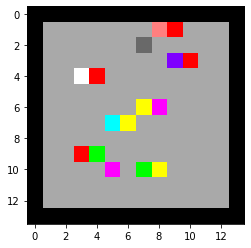

In [46]:
plt.imshow(obs2)